<a href="https://colab.research.google.com/github/ErBadi/Semantic-Analysis-Yelp-Dataset/blob/main/Semantic_Analysis_(wordclouds).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Analysis

## Preliminary code

In [ ]:
#Libraries to import
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt
import string
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from operator import itemgetter
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import sent_tokenize, word_tokenize
#We have to download some semantic packages from nltk to operate with them
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# We read the dataset
review_df = pd.read_csv("/content/drive/MyDrive/REVIEWS BIG DATA/review_data.csv")

In [ ]:
plt.style.use("dark_background")

The functions that we are going to use definde by us are the following:

In [ ]:
# This function remove punctuation and stopwords, we will use it in 
#monogram cloud words.
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # Remove noise
    x = [w for w in x.split() if w not in set(stopwords)]  # Remove stopwords
    return ' '.join(x) # Then join the text again into a sentence
# Import from the nltk package the stopwords for english language to remove
i = nltk.corpus.stopwords.words('english')
# Also import punctiation signs to remove
j = list(string.punctuation)
# From checking our results, we add more stopwords that appear
k = ["text_clear", "goo", "mmmm", "etc", "mr", "dont", "ive", "dtype", "loo", "Name"]
# We combine all of them to create our whole stopwords list
stopwords = set(i).union(j).union(k)

In [ ]:
# Lemmatizer allows to get the lemmas of each word 
# to reduce the number of similar words on the word cloud
WNL = nltk.WordNetLemmatizer()

In [ ]:
# This function will clean and tokenize the text
def bi_preprocessing(text):
  text = text.str.cat(sep=' ')                          # Joins all rows in one 
  text = re.sub('[^a-z\s]', '', text.lower())           # Clean noise
  text = text.replace("'", "")                          # Remove " ' " sign
  tokens = nltk.word_tokenize(text)                     # Tokenize
  text = nltk.Text(tokens)                              
  text = [w for w in text if w not in set(stopwords)]   # Clean stopwords
  text = [s for s in text if len(s) != 0]               # Remove all blank text
  return text

In [ ]:
# We create a dataframe to operate with our target best businesses
def best_business(numreview=100):
  top_rated = review_df.loc[review_df["rating"] >= 4]                    # By rating  
  top_reviewed = top_rated["business_id"].value_counts()[:numreview:]    # By number of reviews
  top_reviewed = list(top_reviewed.index.values.tolist())
  top_business = top_rated.loc[top_rated['business_id'].isin(top_reviewed)] 
  return top_business

In [ ]:
#Like the previous function but for neutral
def neutral_business(numreview=100):
  top_rated = review_df.loc[(review_df["rating"] >= 3) & (review_df["rating"] < 4)]
  top_reviewed = top_rated["business_id"].value_counts()[:numreview:]
  top_reviewed = list(top_reviewed.index.values.tolist())
  top_business = top_rated.loc[top_rated['business_id'].isin(top_reviewed)]
  return top_business

In [ ]:
# We create a dataframe to operate with our target best businesses
def worst_business(numreview=100):
  top_rated = review_df.loc[review_df["rating"] < 3]                    # By rating  
  top_reviewed = top_rated["business_id"].value_counts()[:numreview:]    # By number of reviews
  top_reviewed = list(top_reviewed.index.values.tolist())
  top_business = top_rated.loc[top_rated['business_id'].isin(top_reviewed)] 
  return top_business

In [ ]:
# This function creates a dictionary with the bigrams to plot
def bi_create(text):
  #Now we find the bigrams
  finder = BigramCollocationFinder.from_words(text)
  bigram_measures = BigramAssocMeasures()
  scored = finder.score_ngrams(bigram_measures.raw_freq) # Give them a score 

  # Sort highest to lowest based on the score.
  scoredList = sorted(scored, key=itemgetter(1), reverse=True)
  
  # Word_dict is the dictionary we'll use for the word cloud.
  word_dict = {}
  
  listLen = len(scoredList)
  
  # Get the bigram and join the two words y " _ " to see it properly in the plot
  for i in range(listLen):
      word_dict['_'.join(scoredList[i][0])] = scoredList[i][1]
  return word_dict

## Word Clouds

### Complete dataset

First of all, we will analyse the words of the reviews from the whole dataset to see if there are some patterns. We will be fousing on rating as the variable to group businesses. Our categories will be:

*   **More than 4**: Best businesses
*   **Between 3 and 4:** Neutral businesses
*   **Less than 3:** Worst businesses

We will be also taking into account the number of reviews each business has. Since a business with 5.0 in rating and just 10 reviews is not reliable. Then, we will be taking the top businesses in number of reviews for each category. Let's begin.



In [ ]:
# Call our function to create the dataframe with 100 best businesses
top_business = best_business()
top_business.business_id.value_counts()   # Check everything is correct

4JNXUYY8wbaaDmk3BPzlWw    6837
RESDUcs7fIiihp38-d6_6g    5675
DkYS3arLOhA8si5uUEmHOw    4354
K7lWdNUhCbcnEvI0NhGewg    4333
f4x1YBxkLrZg652xt2KR5g    4177
                          ... 
RAh9WCQAuocM7hYM5_6tnw    1343
RJNAeNA-209sctUO0dmwuA    1331
-ed0Yc9on37RoIoG2ZgxBA    1325
nUpz0YiBsOK7ff9k3vUJ3A    1324
JAmQCmczUclNUfZjkNdjQA    1324
Name: business_id, Length: 100, dtype: int64

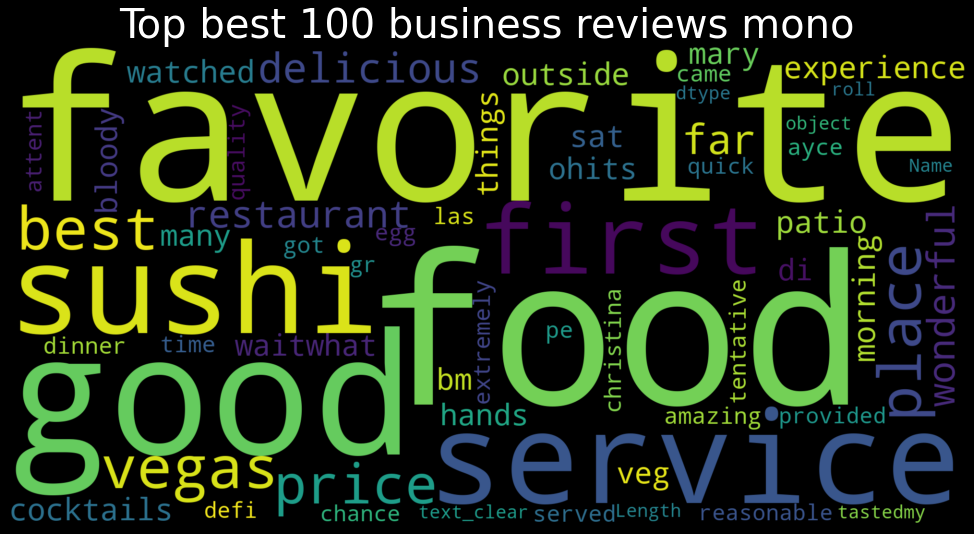

In [ ]:
# We add a new column in our df with the clear text after preprocessing
top_business["text_clear"] = top_business["description"].apply(preprocess)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=200000000)
# Generate word cloud
wc.generate(str(top_business['text_clear']))
# Declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# Add title to the graph
plt.title("Top best 100 business reviews mono", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# Plot and save
plt.show()
wc.to_file("WordCloud_Monogram_Best_All.png")

From this first monogram, the most words that could explain interesting things are the ones related to the kind of food, as we see **sushi** appearing as one of the main ones, which could show that those kind of businesses tend to offer more quality or be more appealing. Also, timing related words appear like **time**, **quick** or **wait**, which means that timing is an important aspect. Finally, **price** and **reasonable** show that customers also value that aspect of the business.

Let's have a look at a bigram to research further.

In [ ]:
# We preprocess the text for our bigram
text = bi_preprocessing(top_business["description"])
# Create the word dictionary with bigrams to plot
word_dict = bi_create(text)

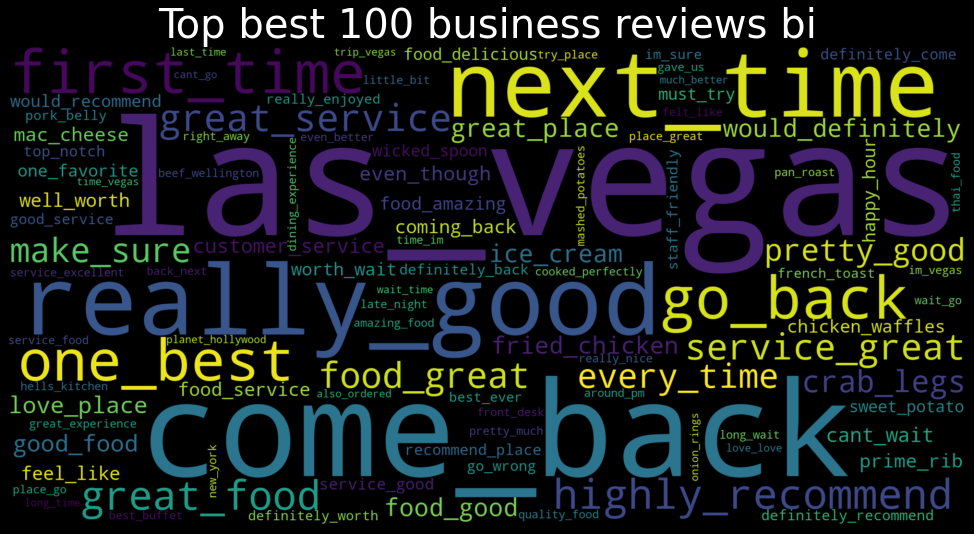

In [ ]:
# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=100)
#Notice we use generate_from_frequencies to operate with bigrams
wc.generate_from_frequencies(word_dict) 
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Top best 100 business reviews bi", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()
wc.to_file("WordCloud_Bigram_Best_All.png")

We clearly see that satisfied customers appeal to be coming back from **come_back**, **go_back** or **next_time**, which can explain the success of those kind of business. Also, recommendation appears to as **highly_recommended**, **definitely_recommended** or **definitely_come**, which may be another way of success, by people recommending their friends or other customers. Finally, there are direct mentions to features like the **service**, the **place** or the **food**.

Final conclusions from top best restaurants would be that **time** is important for customers, since it appears in both plots, also, creating **loyal customers** that return to place and recommend to others. Price surprisingly tends to be not as important, even in the bigram we see that **definitely_worth** could say that it is worth to pay higher prices. So **quality is over price**.

Now we go for the neutral businesses to see if there is something relevant in them.

In [ ]:
# Call our function to create the dataframe with 100 neutral businesses
top_business = neutral_business()
top_business.business_id.value_counts()   # Check everything is correct

K7lWdNUhCbcnEvI0NhGewg    1314
RESDUcs7fIiihp38-d6_6g    1300
FaHADZARwnY4yvlvpnsfGA    1135
eoHdUeQDNgQ6WYEnP2aiRw    1076
AV6weBrZFFBfRGCbcRGO4g    1026
                          ... 
cJWbbvGmyhFiBpG_5hf5LA     267
_PVqHUwjev4oOXomC7pk3w     263
mU3vlAVzTxgmZUu6F4XixA     262
ejaUQ1hYo7Q7xCL1HdPINw     259
ajoqEHnCZTD8-8GqGLq9-Q     258
Name: business_id, Length: 100, dtype: int64

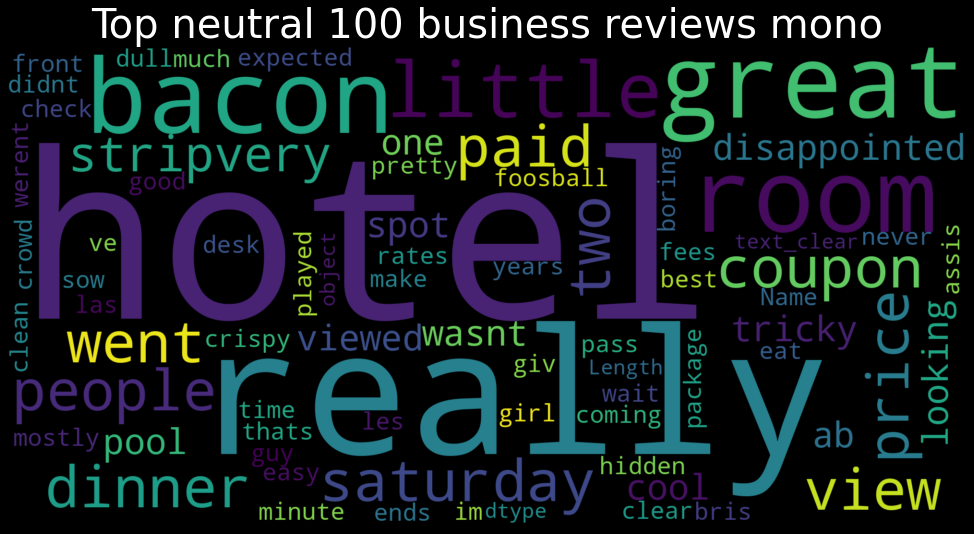

In [ ]:
# We add a new column in our df with the clear text after preprocessing
top_business["text_clear"] = top_business["description"].apply(preprocess)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=200000000)
# Generate word cloud
wc.generate(str(top_business['text_clear']))
# Declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# Add title to the graph
plt.title("Top neutral 100 business reviews mono", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# Plot and save
plt.show()
wc.to_file("WordCloud_Monogram_Neutral_All.png")

In contrast to the previous one, here seems that **hotels are the main business**, not restaurants. Also looks like **price is more important** since we have price, coupon or paid as mentions. Something interesting is disappointed, looks like customers now don't think it's **not worth it to pay** for the service.

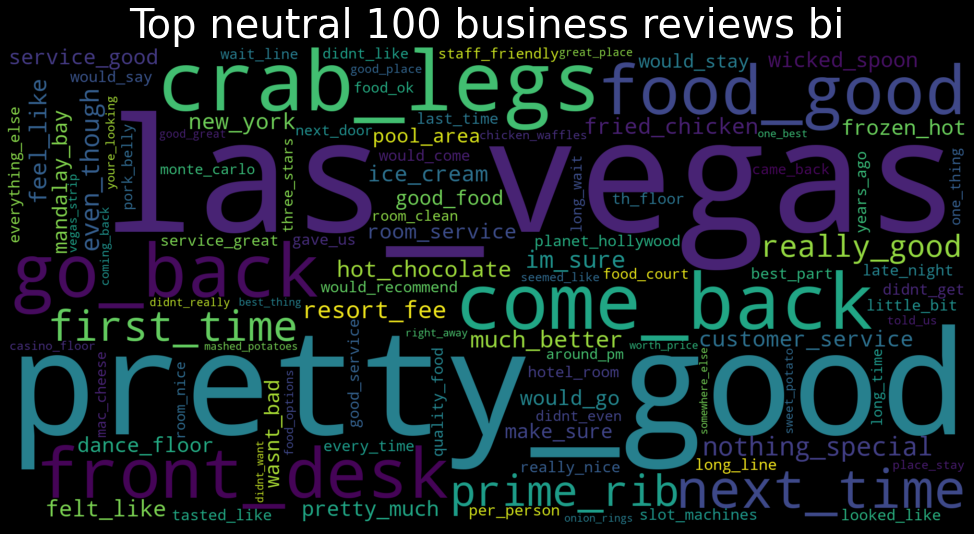

In [ ]:
# We preprocess the text for our bigram
text = bi_preprocessing(top_business["description"])
# Create the word dictionary with bigrams to plot
word_dict = bi_create(text)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=100)
#Notice we use generate_from_frequencies to operate with bigrams
wc.generate_from_frequencies(word_dict) 
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Top neutral 100 business reviews bi", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()
wc.to_file("WordCloud_Bigram_Neutral_All.png")

This bigram shows no particular trends related to the monogram other than the ones related to **price** like **resort_fee** or **per_person**. From the rest, there are both positive and negative comments as expected, even though **more positive** ones. Also, people seem to be **coming back** to those businesses.

Final conclusions would be that **price** starts to appear more, although people seem to be **coming back** to those businesses. Looks like no clear conclusions can be stated further than those, which is what we expected for this range.

Now we go for worst businesses:



In [ ]:
# Call our function to create the dataframe with 100 worst businesses
top_business = worst_business()
all_worst = copy.deepcopy(top_business)   # We will use this in advice section
top_business.business_id.value_counts()   # Check everything is correct

AV6weBrZFFBfRGCbcRGO4g    2029
u_vPjx925UPEG9DFOAAvFQ    1926
El4FC8jcawUVgw_0EIcbaQ    1613
6Q7-wkCPc1KF75jZLOTcMw    1598
RESDUcs7fIiihp38-d6_6g    1593
                          ... 
XXW_OFaYQkkGOGniujZFHg     396
fWetLvfQXqpZcBQLHldUhA     396
-2ToCaDFpTNmmg3QFzxcWg     395
DVfCbJhJUDWRlUfrKzaKOA     395
7EZ4Eu7YJ1ltRCC5jXFJrQ     393
Name: business_id, Length: 100, dtype: int64

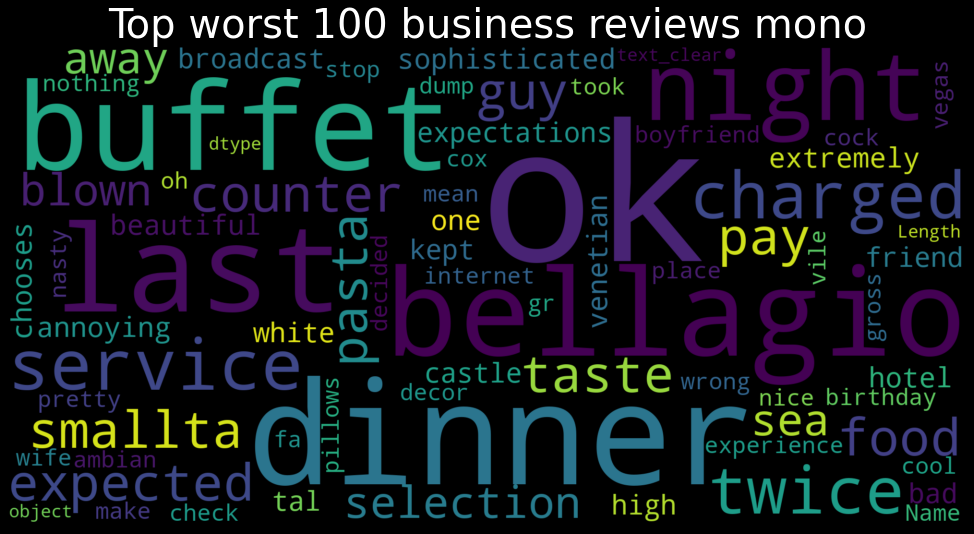

In [ ]:
# We add a new column in our df with the clear text after preprocessing
top_business["text_clear"] = top_business["description"].apply(preprocess)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=200000000)
# Generate word cloud
wc.generate(str(top_business['text_clear']))
# Declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# Add title to the graph
plt.title("Top worst 100 business reviews mono", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# Plot and save
plt.show()
wc.to_file("WordCloud_Monogram_Worst_All.png")

Interesting insights come from here, the most appealing one is that this reviews tend to be more **night related** due to that word appearing with dinner. That along with words like expectations, sophisticated or boyfriend and pay or charged could tell that this businesses tend to be **offering something different than the reality** in them or what the expectations they generate. Then we have direct mentions to **quality of service** like food, experience or internet.

Now bigram analysis:

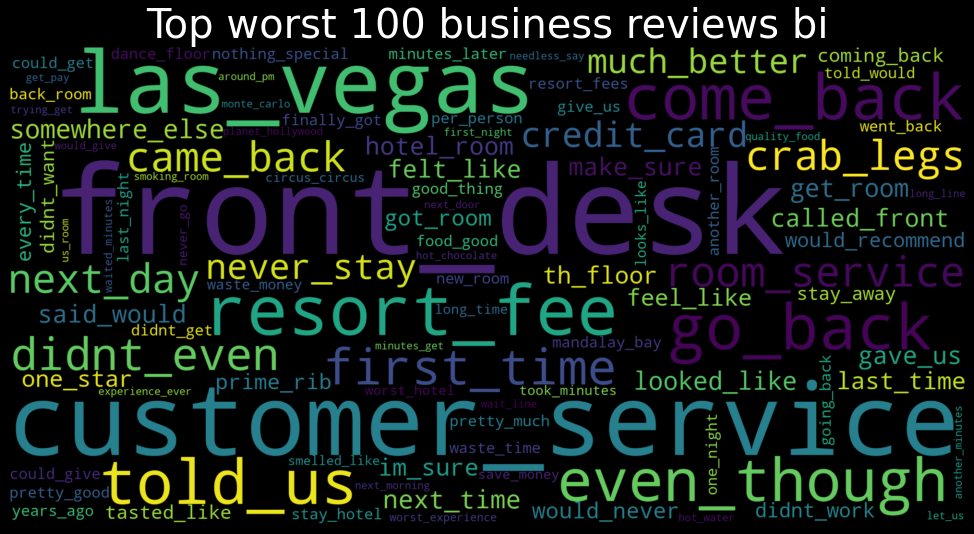

In [ ]:
# We preprocess the text for our bigram
text = bi_preprocessing(top_business["description"])
# Create the word dictionary with bigrams to plot
word_dict = bi_create(text)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=100)
#Notice we use generate_from_frequencies to operate with bigrams
wc.generate_from_frequencies(word_dict) 
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Top worst 100 business reviews bi", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()
wc.to_file("WordCloud_Bigram_Worst_All.png")

First insights are the ones related to **service**, like customer_service, said_would or told_us. Mainly related to personal service as we see. Then, we get the opposite as in the first case: go_back and come_back, which obviously appear as negative meaning that **customers are not returning**. Finally, **price** arises as a big issue with resort_fee.

Final conclusions show that **price** is an important problem, as opposite with best businesses. Also, **customer service** seems a **big issue**. That lead to **no customer loyalty**, and we see that this reviews are more related to **hotel businesses**. Finally, we tend to see that this kind of reviews appear to be **dinner-related**. Which usually means a more formal occasion that, related to the expectations we saw was a problem could explain that **there is a gap between marketing** and reality.

Our overall recommendations would be that for a business to succeed based on this information would be better to give **top-quality better than low quality and low price**. That is supported by the fact that in the opposite case, worst businesses, the problem is that quality is very poor and then price is not worth it.

### Top 3 cities analysis

Now we will conduct a semantic analysis of the top 3 cities in our dataset by number of reviews: **Las Vegas**, **Toronto** and **Phoenix**, in that order. The rules followed to do it are the same as in the previous case. We want to **understand if cities show differences in the success indicators** of businesses. The only difference is that now we will **not be considering neutral ratings** since showed no relevant conclusions previously.

In [ ]:
review_df = pd.read_csv("/content/drive/MyDrive/REVIEWS BIG DATA/review_1.csv")

We will start with Las Vegas.

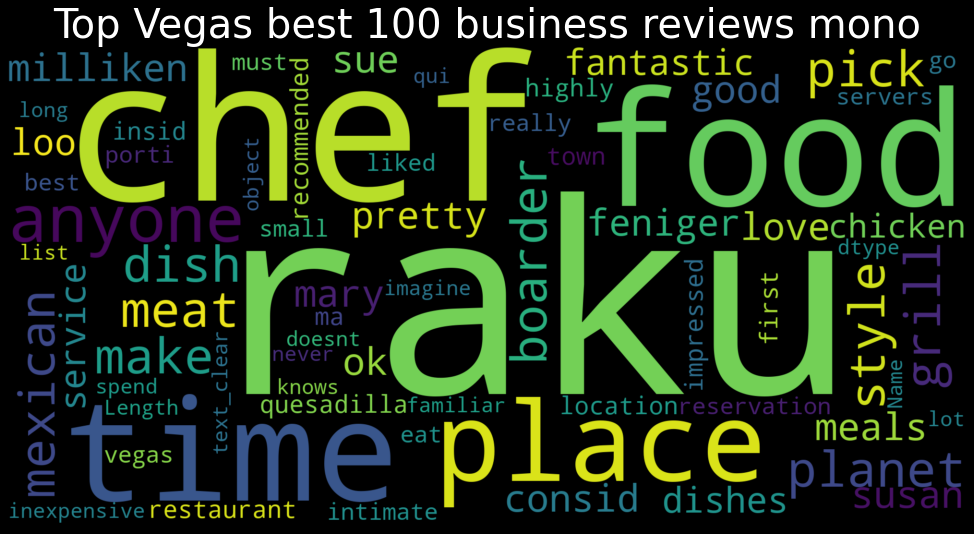

In [ ]:
# Look for best businesses in Vegas
top_business = best_business()
top_business.business_id.value_counts()   # Check everything is correct
# We add a new column in our df with the clear text after preprocessing
top_business["text_clear"] = top_business["description"].apply(preprocess)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=200000000)
# Generate word cloud
wc.generate(str(top_business['text_clear']))
# Declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# Add title to the graph
plt.title("Top Vegas best 100 business reviews mono", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# Plot and save
plt.show()
wc.to_file("WordCloud_Monogram_Best_Vegas.png")

Most interesting words are the ones related to kind of restaurants, like mexican or raku (Raku is a japanese preparation technique), so again, **japanese restaurants** seems to do a great job. So, **themes seems to matter**. Then we have similar insights as previous ones.

Now we go for bigram:

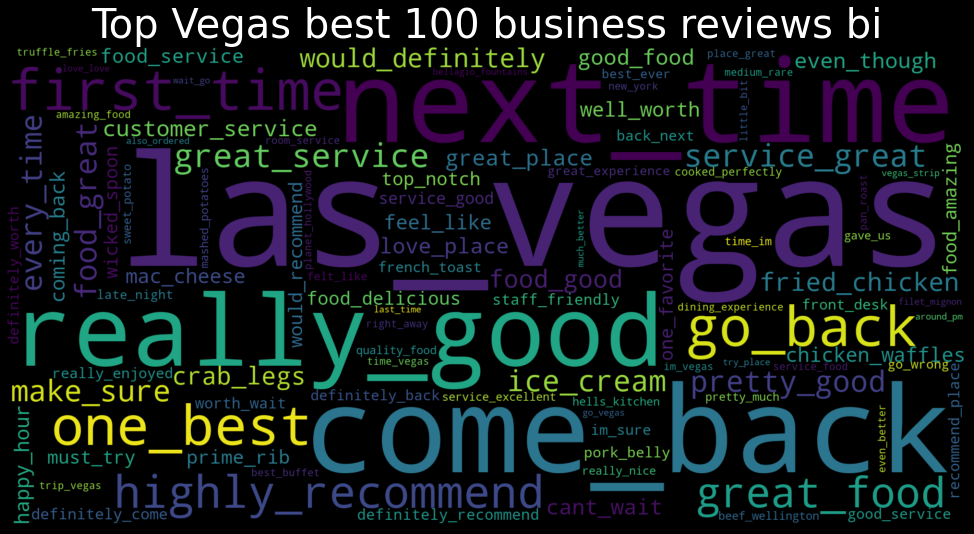

In [ ]:
# We preprocess the text for our bigram
text = bi_preprocessing(top_business["description"])
# Create the word dictionary with bigrams to plot
word_dict = bi_create(text)
# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=100)
#Notice we use generate_from_frequencies to operate with bigrams
wc.generate_from_frequencies(word_dict) 
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Top Vegas best 100 business reviews bi", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()
wc.to_file("WordCloud_Bigram_Best_Vegas.png")

No important differences more than **specific food types** (like pork_belly) between this and the general one found.

Now let's check worst businesses:

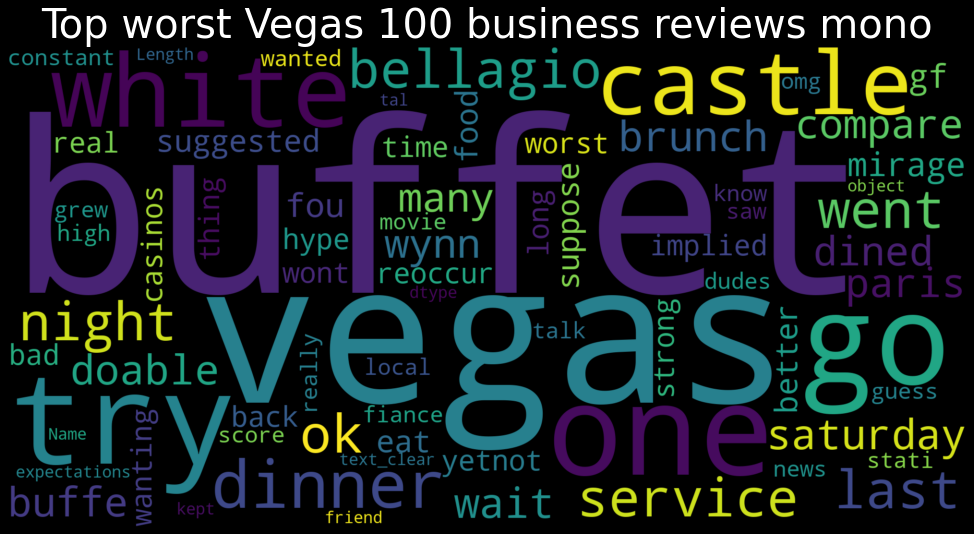

In [ ]:
# Call our function to create the dataframe with 100 best businesses
top_business = worst_business()
top_business.business_id.value_counts()   # Check everything is correct
# We add a new column in our df with the clear text after preprocessing
top_business["text_clear"] = top_business["description"].apply(preprocess)
# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=200000000)
# Generate word cloud
wc.generate(str(top_business['text_clear']))
# Declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# Add title to the graph
plt.title("Top worst Vegas 100 business reviews mono", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# Plot and save
plt.show()
wc.to_file("WordCloud_Monogram_Worst_Vegas.png")

The only difference from previous analysis is that price-related issues do not appear, so **quality seems to be the biggest issue, not depending on price**. Again, seems to be dinner-related reviews. And we have the word fiance, in the overall one we had boyfriend, which along with Saturday could confirm that this **people are rating due to special occasions where they might be more demanding**.

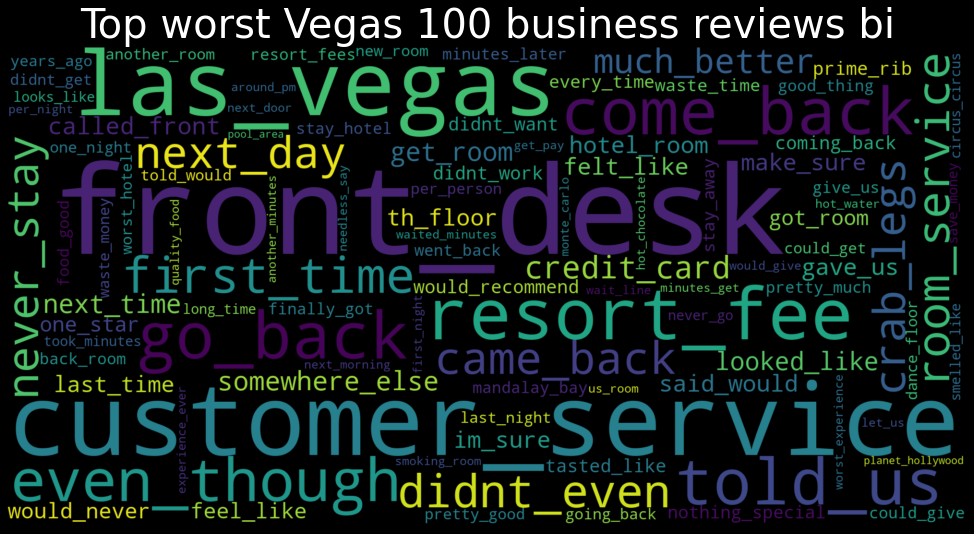

In [ ]:
# We preprocess the text for our bigram
text = bi_preprocessing(top_business["description"])
# Create the word dictionary with bigrams to plot
word_dict = bi_create(text)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=100)
#Notice we use generate_from_frequencies to operate with bigrams
wc.generate_from_frequencies(word_dict) 
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Top worst Vegas 100 business reviews bi", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()
wc.to_file("WordCloud_Bigram_Worst_Vegas.png")

No main differences with previous analysis. 

Now we go for Toronto:

In [ ]:
review2_df = pd.read_csv("/content/drive/MyDrive/REVIEWS BIG DATA/review_2.csv",engine='python', error_bad_lines=False)

Skipping line 723372: unexpected end of data


In [ ]:
review_df = review2_df.loc[review2_df["city"] == "Toronto"]

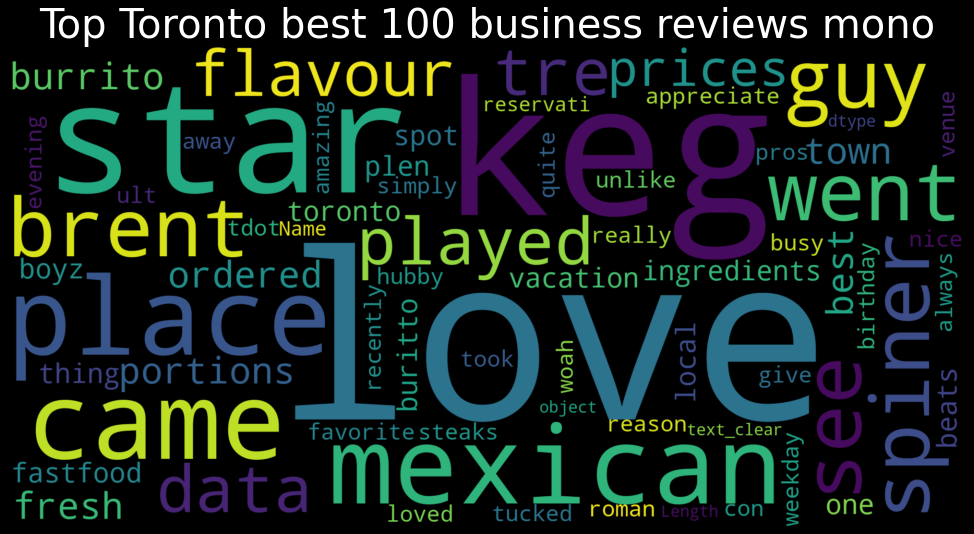

In [ ]:
# Look for best businesses in Toronto
top_business = best_business()
top_business.business_id.value_counts()   # Check everything is correct
# We add a new column in our df with the clear text after preprocessing
top_business["text_clear"] = top_business["description"].apply(preprocess)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=200000000)
# Generate word cloud
wc.generate(str(top_business['text_clear']))
# Declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# Add title to the graph
plt.title("Top Toronto best 100 business reviews mono", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# Plot and save
plt.show()
wc.to_file("WordCloud_Monogram_Best_Toronto.png")

We start to see **differences**, first of all, in the **kind of products**, the main word is "keg", which is a beer barrel, so we see that people in Toronto like beer and value it. Something interesting too is that price appears with a prevalent position in the best reviews, which could tell us that **people value price more than in other cities** in good businesses.

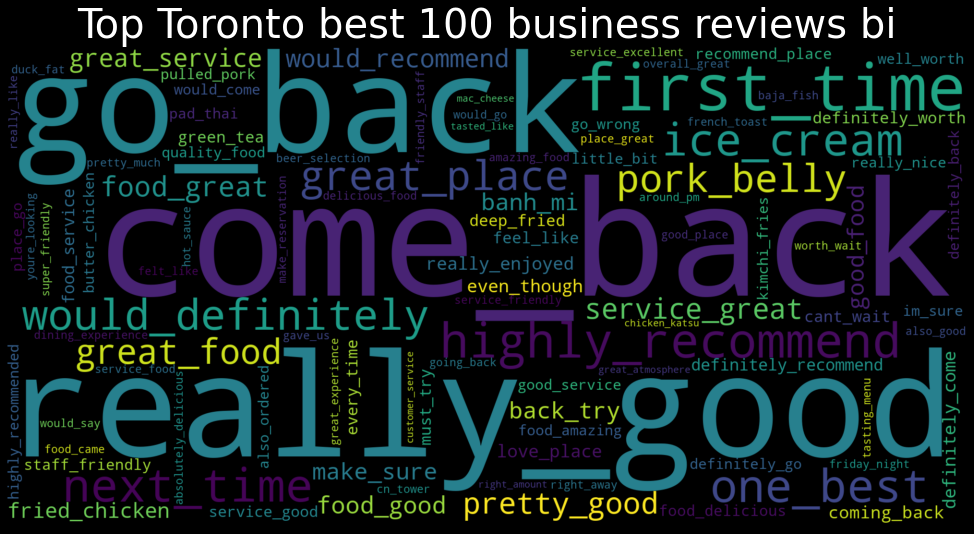

In [ ]:
# We preprocess the text for our bigram
text = bi_preprocessing(top_business["description"])
# Create the word dictionary with bigrams to plot
word_dict = bi_create(text)
# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=100)
#Notice we use generate_from_frequencies to operate with bigrams
wc.generate_from_frequencies(word_dict) 
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Top Toronto best 100 business reviews bi", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()
wc.to_file("WordCloud_Bigram_Best_Toronto.png")

The only differences that we see are the ones related to different types of dishes appearing. **Cultural differences** seem to be important.

From the worst businesses we have:

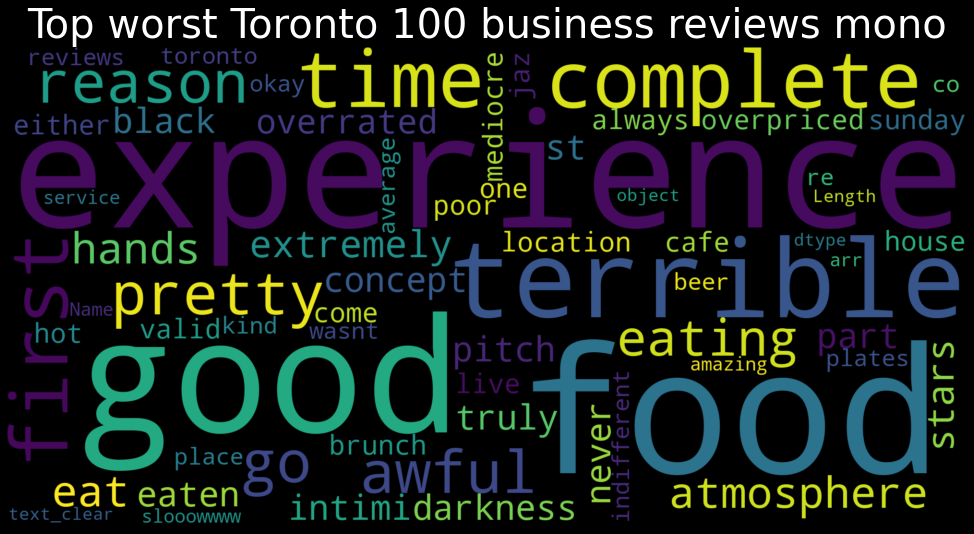

In [ ]:
# Call our function to create the dataframe with 100 best businesses
top_business = worst_business()
top_business.business_id.value_counts()   # Check everything is correct
# We add a new column in our df with the clear text after preprocessing
top_business["text_clear"] = top_business["description"].apply(preprocess)
# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=200000000)
# Generate word cloud
wc.generate(str(top_business['text_clear']))
# Declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# Add title to the graph
plt.title("Top worst Toronto 100 business reviews mono", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# Plot and save
plt.show()
wc.to_file("WordCloud_Monogram_Worst_Toronto.png")

Differences appear in term of complaints, like here valuing more time than before. A difference with Las Vegas is that due to local businesses, here hotels are not the problem, but restaurants appear to be. Interesting that beer appears, that could mean that as we were wondering in Toronto **they value beer**. So, mainly we confirm that **local culture is an important factor in the success or failure of a business**.

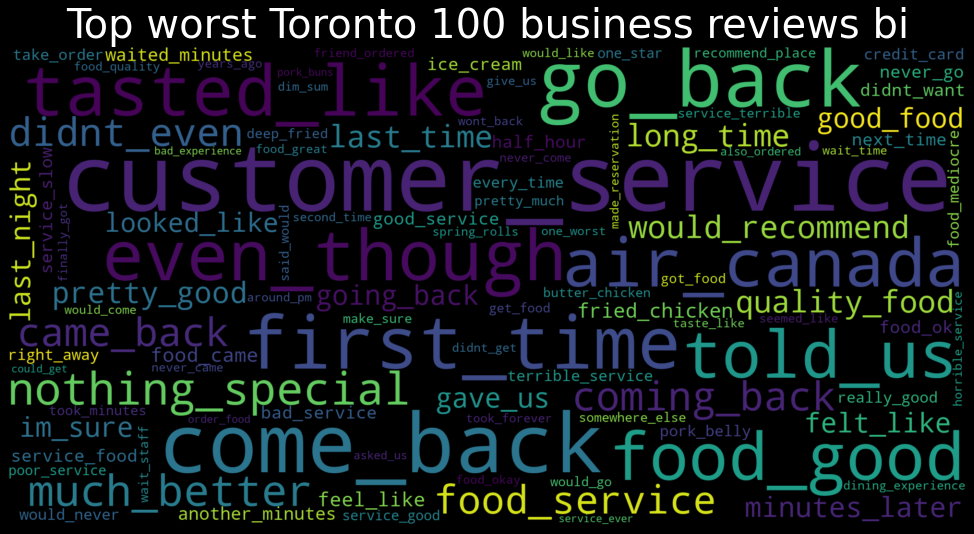

In [ ]:
# We preprocess the text for our bigram
text = bi_preprocessing(top_business["description"])
# Create the word dictionary with bigrams to plot
word_dict = bi_create(text)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=100)
#Notice we use generate_from_frequencies to operate with bigrams
wc.generate_from_frequencies(word_dict) 
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Top worst Toronto 100 business reviews bi", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()
wc.to_file("WordCloud_Bigram_Worst_Toronto.png")

No main differences with previous analysis.

Finally, let's see Phoenix, with approximately the same number of reviews than Toronto.

In [ ]:
review_df = review2_df.loc[review2_df["city"] == "Phoenix"]

From the best restaurants we have:

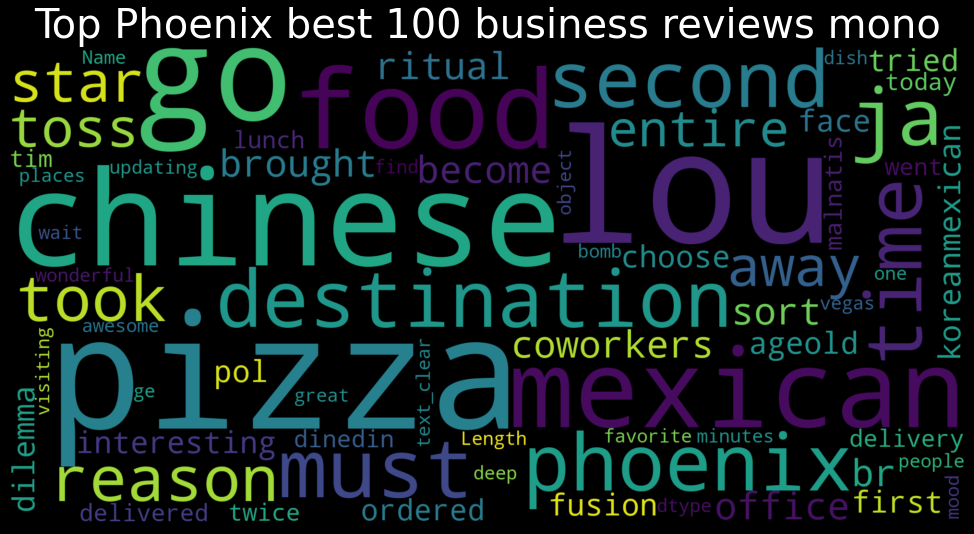

In [ ]:
# Look for best businesses in Phoenix
top_business = best_business()
top_business.business_id.value_counts()   # Check everything is correct
# We add a new column in our df with the clear text after preprocessing
top_business["text_clear"] = top_business["description"].apply(preprocess)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=200000000)
# Generate word cloud
wc.generate(str(top_business['text_clear']))
# Declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# Add title to the graph
plt.title("Top Phoenix best 100 business reviews mono", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# Plot and save
plt.show()
wc.to_file("WordCloud_Monogram_Best_Phoenix.png")

This case is interesting because Phoenix is close to Las Vegas, so we can see if things really change between cities. And yes, they do, as we see, again, **local culture seems to matter** as people in Phoenix value more other kind of food like pizza or chinese. 

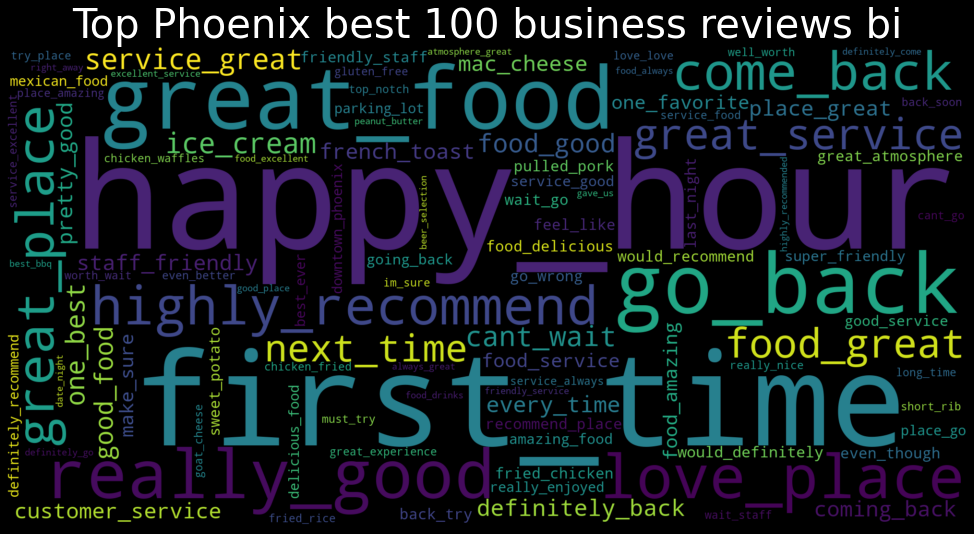

In [ ]:
# We preprocess the text for our bigram
text = bi_preprocessing(top_business["description"])
# Create the word dictionary with bigrams to plot
word_dict = bi_create(text)
# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=100)
#Notice we use generate_from_frequencies to operate with bigrams
wc.generate_from_frequencies(word_dict) 
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Top Phoenix best 100 business reviews bi", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()
wc.to_file("WordCloud_Bigram_Best_Phoenix.png")

Here **we confirm what we were saying about local culture**, in Phoenix, the key success indicator from this plot is having **happy hour**. 

Let's see if this trend continues in the worst businesses.

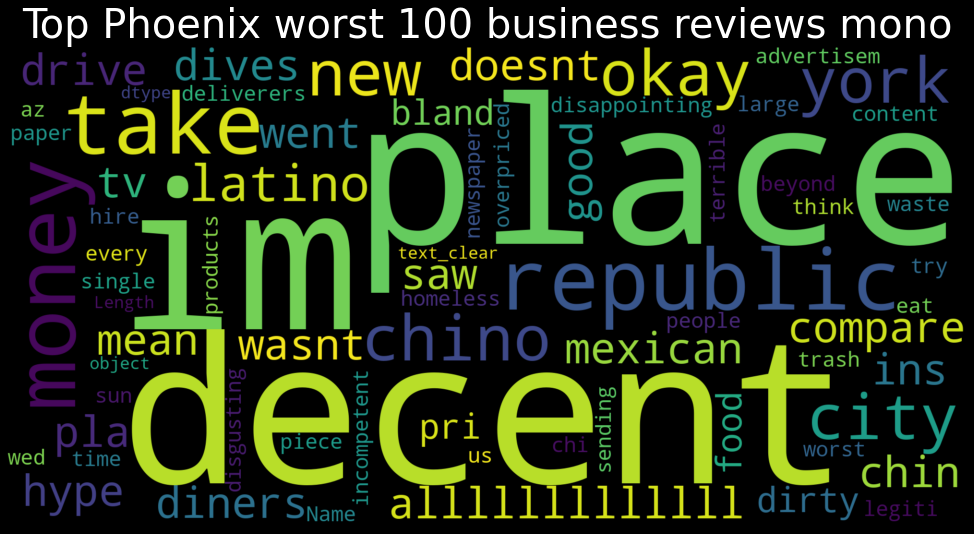

In [ ]:
# Look for best businesses in Vegas
top_business = worst_business()
top_business.business_id.value_counts()   # Check everything is correct
# We add a new column in our df with the clear text after preprocessing
top_business["text_clear"] = top_business["description"].apply(preprocess)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=200000000)
# Generate word cloud
wc.generate(str(top_business['text_clear']))
# Declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# Add title to the graph
plt.title("Top Phoenix worst 100 business reviews mono", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# Plot and save
plt.show()
wc.to_file("WordCloud_Monogram_Worst_Phoenix.png")

Except of **price**, we cannot get very cocnlusive insights from this plot.

Let's see if bigram helps.

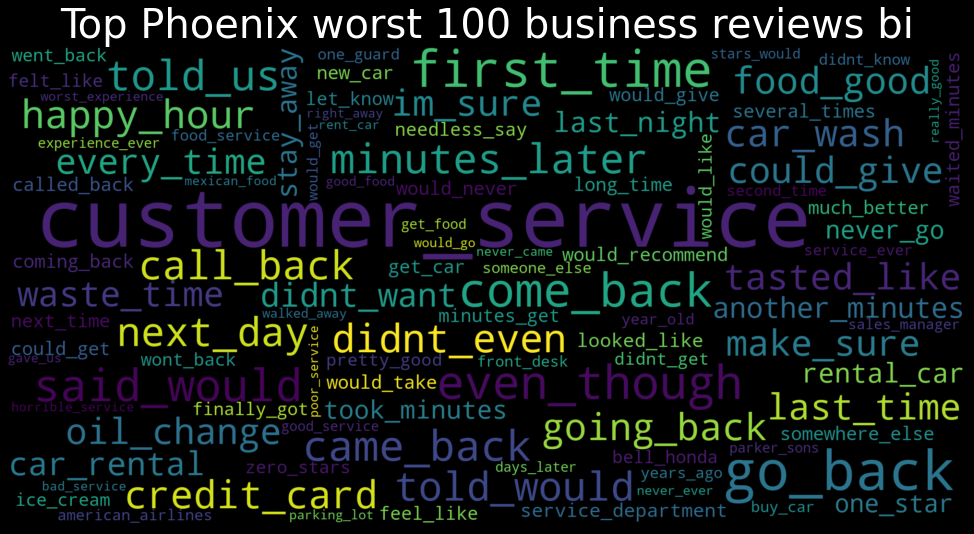

In [ ]:
# We preprocess the text for our bigram
text = bi_preprocessing(top_business["description"])
# Create the word dictionary with bigrams to plot
word_dict = bi_create(text)
# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=100)
#Notice we use generate_from_frequencies to operate with bigrams
wc.generate_from_frequencies(word_dict) 
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Top Phoenix worst 100 business reviews bi", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()
wc.to_file("WordCloud_Bigram_Worst_Phoenix.png")

Here we see that insights are again **not as conclusive as in other cities**, but we see that happy hour is again a **key success indicator** as it is repeated in this worst businesses as an important reason. Customer service is again the main issue, and we see **local businesses** as car rental appearing as the most hated ones.

## Final conclusions and recommendations

From this word cloud analysis we arrived at some important conclusions:


* First of all, **local culture matters** as a key success indicator, and everyone opening a new business should be aware of it. We saw it even between two very close cities as Las Vegas and Phoenix. For deeper local differences, check previous sections.
* The **main reason to failure is customer service**, and **price** appears in a second place, that could be seen as a **consequence** of bad customer services making price not worth it.
* The **main success recommendation for someone opening a business would be to focus on quality**, as we saw, people can be giving **great ratings even having high prices** (they commented it was worth it).
* Successful businesses acquire **customer loyalty** and **recommendations** from their clients, which can make them even more successful.



## Advice data


Let's try to complete our insights from reviews with advices given by users to the top 100 worst businesses by rating and number of reviews in all the dataset.

In [ ]:
advice = pd.read_json("/content/drive/MyDrive/REVIEWS BIG DATA/advice_data_2.json")

In [ ]:
advice.head(3)

index                 user_id  ...                date num_likes
0      0  UPw5DWs_b-e2JRBS-t37Ag  ... 2014-03-27 03:51:24         0
1      1  Ocha4kZBHb4JK0lOWvE0sg  ... 2013-05-25 06:00:56         0
2      2  jRyO2V1pA4CdVVqCIOPc1Q  ... 2011-12-26 01:46:17         0

[3 rows x 6 columns]

Since we see there are so few likes, we will not take that into account to make our division.

In [ ]:
# Select the business that are in advice and in 100 worst list
top_business = advice

In [ ]:
# Just to check if there is any outlier comment, but no
top_business.num_likes.value_counts() 

0     1205140
1       16239
2        1402
3         227
4          51
5          18
6           8
7           4
15          1
12          1
11          1
9           1
8           1
Name: num_likes, dtype: int64

In [ ]:
top_business = top_business.loc[top_business.description.notnull()]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


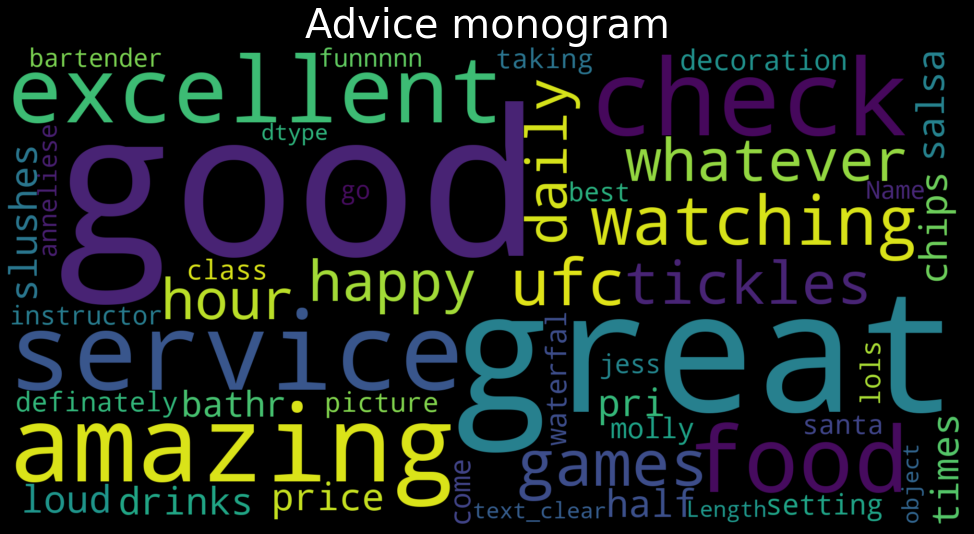

In [ ]:
# We add a new column in our df with the clear text after preprocessing
top_business["text_clear"] = top_business["description"].apply(preprocess)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=200000000)
# Generate word cloud
wc.generate(str(top_business['text_clear']))
# Declare our figure 
plt.figure(figsize=(20,10), facecolor='k')
# Add title to the graph
plt.title("Advice monogram", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# Plot and save
plt.show()
wc.to_file("WordCloud_Monogram_Advice.png")

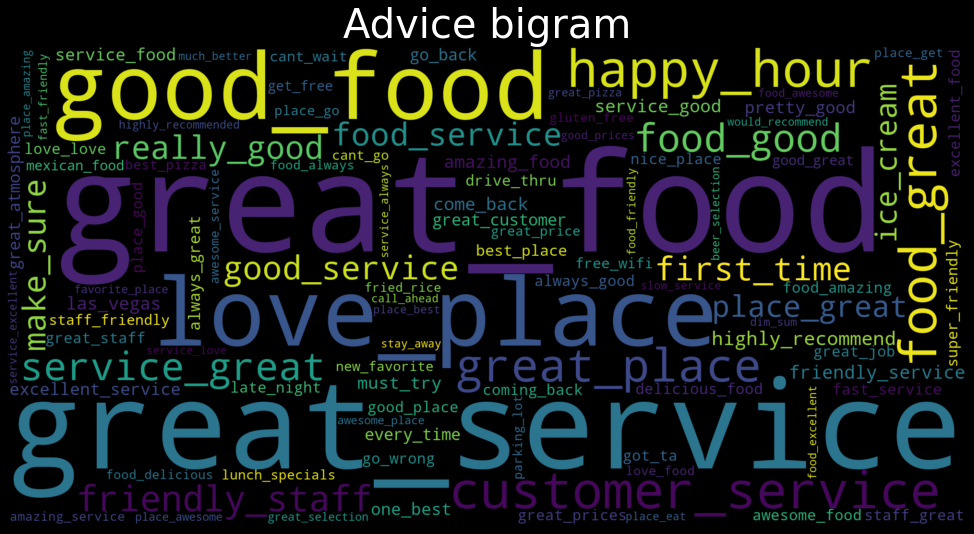

In [ ]:
# We preprocess the text for our bigram
text = bi_preprocessing(top_business["description"])
# Create the word dictionary with bigrams to plot
word_dict = bi_create(text)

# Define wordcloud function from wordcloud library.
wc = WordCloud(width=2000, height=1000, random_state=1, max_words=100)
#Notice we use generate_from_frequencies to operate with bigrams
wc.generate_from_frequencies(word_dict) 
plt.figure(figsize=(20,10), facecolor='k')
plt.title("Advice bigram", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()
wc.to_file("WordCloud_Bigram_Advice.png")

The conclusions from this part are very intuitive: **advices are positive**, so we see people who take the time to comment an advice has the aim to improve a business. Also, they tend to **focus on customer service mainly**, not mentioning price, which clearly fits with our conclusions that **customer service was the most important thing over price**. Also, food is another important area to improve. These plots **match with our conclusions from reviews ones**, no surprises.